# Race Car Models Revisited 


**Prepared by:** Jiabao Nie (jnie2@nd.edu, ACMS 2027) and Jacob Mantooth (jmantoot@nd.edu, ACMS 2027)

Adapted from [Pyomo.DAE Example: Race Car](https://ndcbe.github.io/optimization/notebooks/3/PyomoDAE_car.html) and [The Mountain Car Problem](https://openmdao.github.io/dymos/examples/mountain_car/mountain_car.html).

By the end of this project we hope to:
*   Practice formulating and analyzing optimization problems on paper
*   Develop proficiency in Python and Pyomo
*   Analyze and discuss optimization results


## Install Packages and Load Modules

In [ ]:
# Imports
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()

--2024-10-07 18:10:25--  https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6493 (6.3K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   6.34K  --.-KB/s    in 0s      

2024-10-07 18:10:25 (52.4 MB/s) - ‘helper.py’ saved [6493/6493]

Installing idaes via pip...
idaes was successfully installed
idaes, version 2.6.0


Running idaes get-extensions to install Ipopt, k_aug, and more...
Checking solver versions:
Ipopt 3.13.2 (x86_64-pc-linux-gnu), ASL(20190605)



[K_AUG] 0.1.0, Part of the IDAES PSE framework
Please visit https://idaes.org/ (x86_64-pc-linux-gnu), ASL(20190605)



Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimiz

In [ ]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import pyomo.dae as dae
from pyomo.environ import units
import numpy as np
import math
from tabulate import tabulate

## <font size="6"> 1. Friction Model

### **1.1 Original Model**  
  
You are a race car driver with a simple goal. Drive distance $L$ in the minimal amount of time **but** come to a complete stop at the finish line.

**1.1.1 Problem Statement and Optimal Control Formulation**

Mathematically, the original optimal control problem was defined as:

$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{dt} = v \\
& \frac{dv}{dt} = u - R v^2 \\
& x(t=0) = 0, ~~ x(t=t_f) = L \\
& v(t=0) = 0, ~~ v(t=t_f) = 0 \\
& |u| \leq 10
\end{align*}$$

where $u$ is the acceleration/braking (your control variable) and $R$ is the drag coefficient (parameter).  **Notice:** $Rv^2$ represents aerodynamic drag.

**1.1.2 Declaring original Model with Pyomo.DAE**

In [ ]:
## Define Original Model
def original_model():
    # Define the  model
    m = pyo.ConcreteModel()

    # Deine the model parameters
    m.R = pyo.Param(initialize=0.001, units=1/units.m)  # Friction factor
    m.L = pyo.Param(initialize=100.0, units=units.m)    # Final position

    # Define time
    m.tau = dae.ContinuousSet(bounds=(0,1))             # Dimensionless time set
    m.tf = pyo.Var(initialize=1, units=units.s)         # Final time

    # Define remaining algebraic variables
    m.x = pyo.Var(m.tau, bounds=(0,m.L+50*units.m), units=units.m)                              # Position
    m.v = pyo.Var(m.tau, bounds=(0,None), units=units.m/units.s)                        # Velocity
    m.u = pyo.Var(m.tau, bounds=(-10.0,10.0),initialize=0, units=units.m/units.s/units.s) # Acceleration

    # Define derivative variables
    m.dx = dae.DerivativeVar(m.x)
    m.dv = dae.DerivativeVar(m.v)

    # Declare the objective (minimize final time)
    m.obj = pyo.Objective(expr=m.tf)

    # Define the constraints
    # position
    def _ode1(m,i):
        if i == 0 :
            return pyo.Constraint.Skip
        return m.dx[i] == m.tf * m.v[i]
    m.ode1 = pyo.Constraint(m.tau, rule=_ode1)

    # velocity
    def _ode2(m,i):
        if i == 0 :
            return pyo.Constraint.Skip
        return m.dv[i] == m.tf*(m.u[i] - m.R*m.v[i]**2)
    m.ode2 = pyo.Constraint(m.tau, rule=_ode2)

    # Define the inital/boundary conditions
    def _init(m):
        yield m.x[0] == 0
        yield m.x[1] == m.L
        yield m.v[0] == 0
        yield m.v[1] == 0

    m.initcon = pyo.ConstraintList(rule=_init)

    return m

### **1.2 Friction Model**  
  
However, this approach is quite generalized and overlooks certain physical constraints such as road friction and tire grip. These factors are critical in real-world applications and need to be considered to make the model more realistic. For our project we will add these to make it more realistic.

**1.2.1 Problem Statement and Optimal Control Formulation**

Our new problem will be formulated as the following:
$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{dt} = v \\
& \frac{dv}{dt} = u - R v^2 - (Cv + μ) g \\
& x(t=0) = 0, ~~ x(t=t_f) = L \\
& v(t=0) = 0, ~~ v(t=t_f) = 0\\
&|u| \leq 10\\
\end{align*}$$

**Objective**:
The goal is to **minimize the final time** $t_f $, meaning we want the system to reach the final state in the shortest possible time.

 **Constraints**:
1. System dynamics:
   - $ \frac{dx}{dt} = v $: This equation describes how the position $ x $ changes with time, where $ v $ represents the velocity of the system.
   - $ \frac{dv}{dt} = u - R v^2 - (Cv + μ) g $: This describes how the velocity $ v $ evolves over time. The velocity changes according to the control input $u $, the resistance term $ Rv^2 $, and a damping term $ \beta v $.
     - $ u $ is a control variable (acceleration),
     - $ R v^2 $ represents aerodynamic drag,
     - $ (Cv + μ) g $ represents road friction, where $\mu$ is the normal coefficient of friction, and $c>0$ relates to tire deformation or heating effects.

2. Boundary conditions:
   - $ x(0) = 0 $, $ x(t_f) = L $: The position $ x $ is initially at 0, and at time $ t_f $, it must reach $ L $.
   - $ v(0) = 0 $, $v(t_f) = 0 $: The velocity is initially zero and must also be zero at the final time $ t_f $.

3. Control constraints:
   - $ |u| \leq 10 $: The control $ u $ is bounded, meaning the system can only apply a limited amount of control force or acceleration. This constraint ensures that the control input does not exceed certain physical limits.

**1.2.2 Scale Time**

Let $t = τ⋅t_f$ where $τ ∈ [0,1]$. Thus $dt = t_fdτ$. The optimal control problem becomes:  
$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{dτ} = t_f v \\
& \frac{dv}{dτ} =  t_f [u - R v^2 - (Cv + μ) g] \\
& x(τ=0) = 0, ~~ x(τ=1) = L \\
& v(τ=0) = 0, ~~ v(τ=1) = 0\\
&|u| \leq 10\\
\end{align*}$$

**1.2.3 Declaring Friction Model with Pyomo.DAE**

In [ ]:
## Define Friction Model
def friction_model(c,mu):

    # Define the  model
    m = pyo.ConcreteModel()

    # Deine the model parameters
    m.R = pyo.Param(initialize=0.001, units=1/units.m)  # Aerodynamic drag
    m.L = pyo.Param(initialize=100.0, units=units.m)    # Final position
    m.g = pyo.Param(initialize=9.81, units=units.m/units.s/units.s) # Gravity
    m.c = pyo.Param(initialize=c, units=units.s/units.m)       # Tire coefficient
    m.mu = pyo.Param(initialize=mu, units=1)            # Road friction coefficient

    # Define time
    m.tau = dae.ContinuousSet(bounds=(0,1))             # Dimensionless time set
    m.tf = pyo.Var(initialize=1, units=units.s)         # Final time

    # Define remaining algebraic variables
    m.x = pyo.Var(m.tau, bounds=(0,m.L+50*units.m), units=units.m)                              # Position
    m.v = pyo.Var(m.tau, bounds=(0,None), units=units.m/units.s)                        # Velocity
    m.u = pyo.Var(m.tau, bounds=(-10.0,10.0),initialize=0, units=units.m/units.s/units.s) # Acceleration

    # Define derivative variables
    m.dx = dae.DerivativeVar(m.x)
    m.dv = dae.DerivativeVar(m.v)

    # Declare the objective (minimize final time)
    m.obj = pyo.Objective(expr=m.tf)

    # Define the constraints
    # position
    def _ode1(m,i):
        if i == 0 :
            return pyo.Constraint.Skip
        return m.dx[i] == m.tf * m.v[i]
    m.ode1 = pyo.Constraint(m.tau, rule=_ode1)

    # velocity
    def _ode2(m,i):
        if i == 0 :
            return pyo.Constraint.Skip
        return m.dv[i] == m.tf*(m.u[i] - m.R*m.v[i]**2 - (m.c*m.v[i]+m.mu)*m.g)
    m.ode2 = pyo.Constraint(m.tau, rule=_ode2)

    # Define the inital/boundary conditions
    def _init(m):
        yield m.x[0] == 0
        yield m.x[1] == m.L
        yield m.v[0] == 0
        yield m.v[1] == 0

    m.initcon = pyo.ConstraintList(rule=_init)

    return m

### **1.3 Solve & Plot**

**Discretize/Transcribe and Solve**

In [ ]:
## Discretize and Solve Orignal & Friction
def model_solve(m):

  # Declare the discretizer
  discretizer = pyo.TransformationFactory('dae.collocation')
  discretizer.apply_to(m,nfe=100,scheme='LAGRANGE-RADAU',ncp=3)

  # Solve
  solver = pyo.SolverFactory('ipopt')
  solver.solve(m,tee=False)

  # force piecewise constant controls (acceleration) over each finite element
  m = discretizer.reduce_collocation_points(m,var=m.u,ncp=1,contset=m.tau)

  print("final time = %6.2f seconds" %(pyo.value(m.tf)))

  return m

**Extract Data**

In [ ]:
## Extract Data and Make List
def data_extract(m):
    # Define empty lists
    x = []    # position, units of length
    v = []    # velocity, units of length per time
    u = []    # acceleration, units of length per time squared
    time=[]   # time
    tf = pyo.value(m.tf)

    # Loop over time and append the solution values for each variable to their respective lists
    for i in m.tau:
        time.append(i*tf)
        x.append(pyo.value(m.x[i]))
        v.append(pyo.value(m.v[i]))
        u.append(pyo.value(m.u[i]))

    return time, x, v, u

**Plot Results**

In [ ]:
## Plot the Results
def plot_data(data_dict):
    # Make a figure with a specific size
    plt.figure(figsize=(12,4))

    # Format subplot 1 (position)
    plt.subplot(131)
    for key, (time, x, _, _) in data_dict.items():
        plt.plot(time, x, linewidth=3, label=key)
    plt.title('Location (m)', fontsize=16, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=16, fontweight='bold')
    plt.tick_params(direction="in", labelsize=15)

    # Format subplot 2 (velocity)
    plt.subplot(132)
    for key, (time, _, v, _) in data_dict.items():
        plt.plot(time, v, linewidth=3, label=key)
    plt.title('Velocity (m/s)', fontsize=16, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=16, fontweight='bold')
    plt.tick_params(direction="in", labelsize=15)

    # Format subplot 3 (acceleration)
    plt.subplot(133)
    for key, (time, _, _, u) in data_dict.items():
        plt.plot(time, u, linewidth=3, label=key)
    plt.title('Acceleration (m/s$^2$)', fontsize=16, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=16, fontweight='bold')
    plt.tick_params(direction="in", labelsize=15)
    plt.legend(fontsize='small')

    # Display the plots
    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()

### **1.4 Results**  
  
We first check the consistency by setting the friction to be 0 in the friction model. Then, we exam the new model with different parameters.

**Checking Consistency**

final time =   6.33 seconds
final time =   6.33 seconds


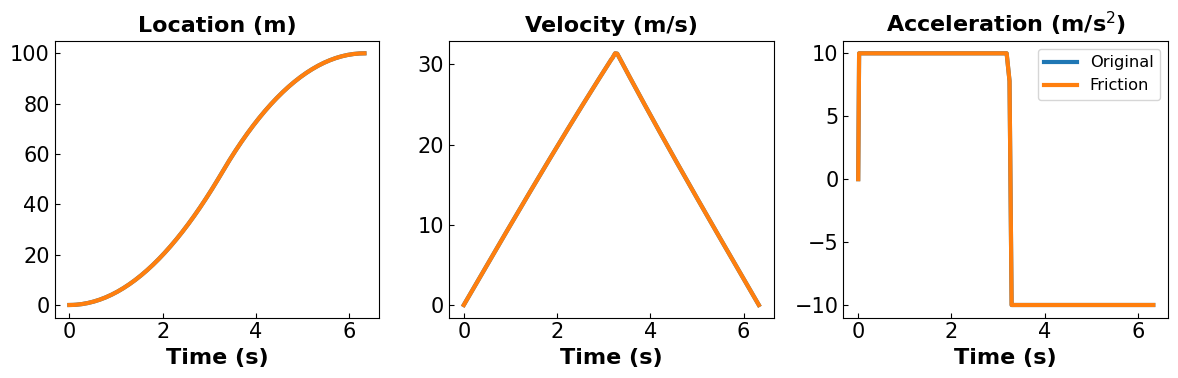

In [ ]:
# Original Model
original_m = original_model()
original_m = model_solve(original_m)
time1, x1, v1, u1 = data_extract(original_m)
# Friction Model with 0 Friction
m_checking = friction_model(0,0)
m_checking = model_solve(m_checking)
time2, x2, v2, u2 = data_extract(m_checking)

data_dict = {
    "Original": (time1, x1, v1, u1),
    "Friction": (time2, x2, v2, u2)
}

plot_data(data_dict)

**Different Parameters**

+--------+------------------------+-----------------------------+
| Tire   |   Normal Coefficient C |   Deformation Coefficient μ |
+========+========================+=============================+
| Tire 1 |                   0    |                       0     |
+--------+------------------------+-----------------------------+
| Tire 2 |                   0.07 |                       0.002 |
+--------+------------------------+-----------------------------+
| Tire 3 |                   0.04 |                       0.01  |
+--------+------------------------+-----------------------------+
| Tire 4 |                   0.02 |                       0.1   |
+--------+------------------------+-----------------------------+
final time =   6.33 seconds
final time =   8.98 seconds
final time =   7.26 seconds
final time =   6.75 seconds


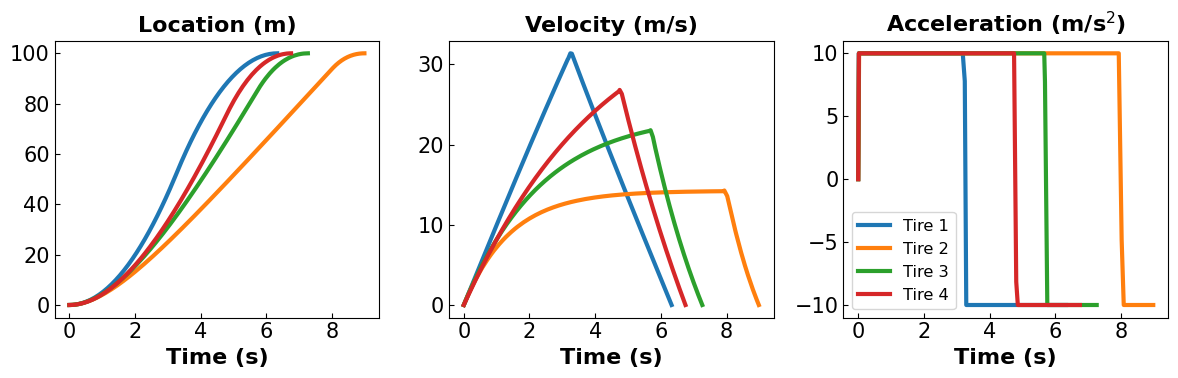

In [ ]:
# Parameter list
c = [0, 0.07, 0.04, 0.02]
mu = [0, 0.002, 0.01, 0.1]

# Table of tires
tire = [
    ["Tire 1", c[0], mu[0]],
    ["Tire 2", c[1], mu[1]],
    ["Tire 3", c[2], mu[2]],
    ["Tire 4", c[3], mu[3]],
]
headers = ["Tire", "Normal Coefficient C", "Deformation Coefficient μ"]
print(tabulate(tire, headers, tablefmt="grid"))

# Create an empty dictionary to store results
data_dict = {}

for i in range(len(c)):
    m_i = friction_model(c[i],mu[i])
    m_i = model_solve(m_i)

    time_i, x_i, v_i, u_i = data_extract(m_i)

    model_label = f"Tire {i+1}"
    data_dict[model_label] = (time_i, x_i, v_i, u_i)

plot_data(data_dict)

## <font size="6"> 2. Uphill/Downhill/Flat

The road isn't always flat, so let's introduce slopes into the model. Solve the optimization problem for navigating uphills/downhills:  

$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{dt} = v \\
& \frac{dv}{dt} = u - g\sin(ϕ)- R v^2 - (Cv + \mu)g\cos(ϕ)  \\
& x(t=0) = 0, ~~ x(t=t_f) = L \\
& v(t=0) = 0, ~~ v(t=t_f) = 0 \\
& |u| \leq 10
\end{align*}$$  

Uphill: $\phi>0$, Downhill: $\phi<0$.

**Declaring Uphill/Downhill Model with Pyomo.DAE**

In [ ]:
## Define Friction Model
def friction_uphill_model(c,mu,phi):

    # Define the  model
    m = pyo.ConcreteModel()

    # Deine the model parameters
    m.R = pyo.Param(initialize=0.001, units=1/units.m)  # Aerodynamic drag
    m.L = pyo.Param(initialize=100.0, units=units.m)    # Final position
    m.g = pyo.Param(initialize=9.81, units=units.m/units.s/units.s) # Gravity
    m.c = pyo.Param(initialize=c, units=units.s/units.m)       # Tire coefficient
    m.mu = pyo.Param(initialize=mu, units=1)            # Road friction coefficient

    # Define time
    m.tau = dae.ContinuousSet(bounds=(0,1))             # Dimensionless time set
    m.tf = pyo.Var(initialize=1, units=units.s)         # Final time

    # Define remaining algebraic variables
    m.x = pyo.Var(m.tau, bounds=(0,m.L+50*units.m), units=units.m)                              # Position
    m.v = pyo.Var(m.tau, bounds=(0,None), units=units.m/units.s)                        # Velocity
    m.u = pyo.Var(m.tau, bounds=(-10.0,10.0),initialize=0, units=units.m/units.s/units.s) # Acceleration

    # Define derivative variables
    m.dx = dae.DerivativeVar(m.x)
    m.dv = dae.DerivativeVar(m.v)

    # Declare the objective (minimize final time)
    m.obj = pyo.Objective(expr=m.tf)

    # Define the constraints
    # position
    def _ode1(m,i):
        if i == 0 :
            return pyo.Constraint.Skip
        return m.dx[i] == m.tf * m.v[i]
    m.ode1 = pyo.Constraint(m.tau, rule=_ode1)

    # velocity
    def _ode2(m,i):
        if i == 0 :
            return pyo.Constraint.Skip
        return m.dv[i] == m.tf*(m.u[i] - m.g*np.sin(phi) - m.R*m.v[i]**2 - (m.c*m.v[i]+m.mu)*m.g*np.cos(phi))
    m.ode2 = pyo.Constraint(m.tau, rule=_ode2)

    # Define the inital/boundary conditions
    def _init(m):
        yield m.x[0] == 0
        yield m.x[1] == m.L
        yield m.v[0] == 0
        yield m.v[1] == 0

    m.initcon = pyo.ConstraintList(rule=_init)

    return m

**Checking Consistency**

final time =   6.40 seconds
final time =   6.40 seconds


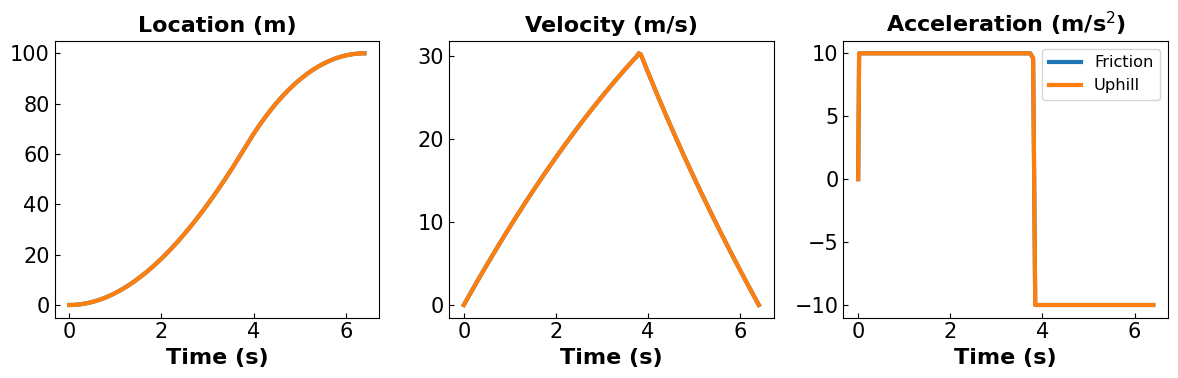

In [ ]:
# Friction Model
m_friction = friction_model(0.01,0.01)
m_friction = model_solve(m_friction)
time1, x1, v1, u1 = data_extract(m_friction)

# Uphill Model with 0 Slope
m_checking = friction_uphill_model(0.01,0.01,0.0)
m_checking = model_solve(m_checking)
time2, x2, v2, u2 = data_extract(m_checking)

data_dict = {
    "Friction": (time1, x1, v1, u1),
    "Uphill": (time2, x2, v2, u2)
}

plot_data(data_dict)

**Different Slopes** (uphill:positive , downhills:negative)

final time =   6.40 seconds
final time =   6.40 seconds
final time =   6.84 seconds
final time =   7.83 seconds


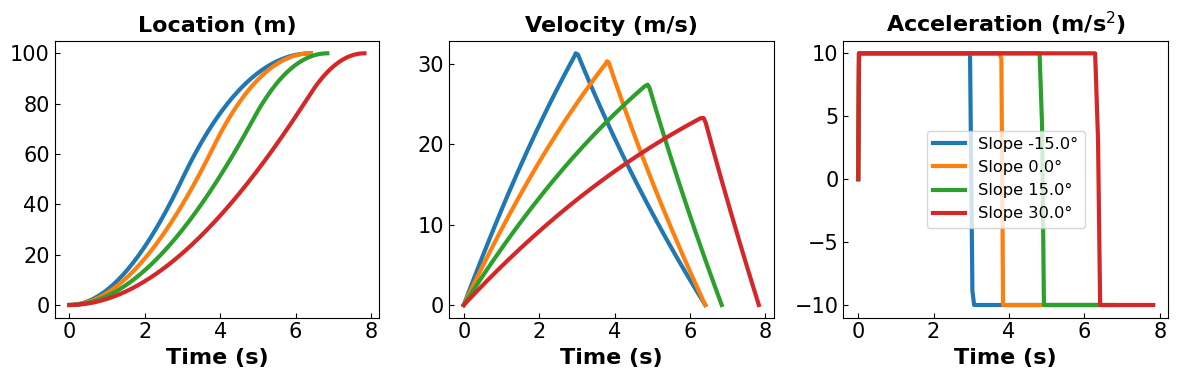

In [ ]:
# Parameter list
phi = [-np.pi/12, 0, np.pi/12, np.pi/6]

# Create an empty dictionary to store results
data_dict1 = {}

for i, angle in enumerate(phi):
    # Create and solve the model for each angle
    m_i = friction_uphill_model(0.01, 0.01, angle)
    m_i = model_solve(m_i)

    # Extract the data
    time_i, x_i, v_i, u_i = data_extract(m_i)

    # Convert the angle to degrees for a clearer label
    angle_deg = np.degrees(angle)
    model_label = f"Slope {angle_deg:.1f}°"

    # Store the data in the dictionary
    data_dict1[model_label] = (time_i, x_i, v_i, u_i)

plot_data(data_dict1)

## <font size="6"> 3. Gas Consumption Model

Recall that our model was  

$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{dt} = v \\
& \frac{dv}{dt} =  u - g\sin(ϕ)- R v^2 - (Cv + \mu)g\cos(ϕ)\\
& x(t=0) = 0, ~~ x(t=t_f) = L \\
& v(t=0) = 0, ~~ v(t=t_f) = 0\\\
&|u| \leq 10\\
\end{align*}$$

Yet this still has issue, as it doesnt account for the amount of gas we have. Let's fix this:  


### **3.1 Problem Statement and Optimal Control Formulation**

The power $P$ (unit: $W$) required to maintain the acceleration can be calculated using:
$$\begin{equation*}
P = m ⋅ v⋅ [|u|  +g\sin(ϕ)+R v^2 + (Cv + \mu)g\cos(ϕ)]
\end{equation*}$$
The gas $G$ (unit: $L$) need to provide this amount of power can be expressed with:
$$\begin{equation*}
\frac{dG}{dt} = - k ⋅ P
\end{equation*}$$
where $k=\eta ⋅ r$ (unit: $L/J$). $\eta < 1$ is the engine efficiency (unit: 1) and $r$ is the gas consumption coefficient (unit: $L/J$), defined as the volume of fuel consumed per joule of energy produced.

We want to solve the following optimal control problem:
$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{dt} = v \\
& \frac{dv}{dt} = u - R v^2 - (Cv + μ)g \\
&\frac{dG}{dt}= - d ⋅ v⋅[|u|  +g\sin(ϕ)+R v^2 + (Cv + \mu)g\cos(ϕ)] \\
& x(t=0) = 0, ~~ x(t=t_f) = L \\
& v(t=0) = 0, ~~ v(t=t_f) = 0\\
& G(t=0) = G_0, ~~ G(t) \geq 0\\
&|u| \leq 10
\end{align*}$$

**3.1.1 Scale Time**

Let $t = τ⋅t_f$ where $τ ∈ [0,1]$. Thus $dt = t_fdτ$. The optimal control problem becomes:  
$$\begin{align*}
\min_{u} \quad & t_f \\
\mathrm{s.t.} \quad & \frac{dx}{dτ} = t_f v \\
& \frac{dv}{dτ} =  t_f [u - R v^2 - (Cv + μ) g] \\
&\frac{dG}{dτ}= - d t_f ⋅v⋅[|u|  +g\sin(ϕ)+R v^2 + (Cv + \mu)g\cos(ϕ)] \\
& x(τ=0) = 0, ~~ x(τ=1) = L \\
& v(τ=0) = 0, ~~ v(τ=1) = 0\\
& G(τ=0) = G_0, ~~ G(τ) \geq 0\\
&|u| \leq 10
\end{align*}$$

It is easy to see that our degree of freedom of our final equation would be N-5

**3.1.2 Declaring Gas Consumption Model with Pyomo.DAE**

In [ ]:
## Define Gas Consumption Model
def gas_consumption_model(c,mu,G_initial,phi):

    # Define the  model
    m = pyo.ConcreteModel()

    # Deine the model parameters
    m.R = pyo.Param(initialize=0.001, units=1/units.m)  # Aerodynamic drag
    m.L = pyo.Param(initialize=100.0, units=units.m)    # Final position
    m.g = pyo.Param(initialize=9.81, units=units.m/units.s/units.s) # Gravity
    m.c = pyo.Param(initialize=c, units=units.s/units.m)       # Tire coefficient
    m.mu = pyo.Param(initialize=mu, units=1)            # Road friction coefficient
    m.d = pyo.Param(initialize=1, units=units.L/units.J)    # Gas consumption coefficient

    # Define time
    m.tau = dae.ContinuousSet(bounds=(0,1))             # Dimensionless time set
    m.tf = pyo.Var(initialize=1, units=units.s)         # Final time

    # Define remaining algebraic variables
    m.x = pyo.Var(m.tau, bounds=(0,m.L+50*units.m), units=units.m)                              # Position
    m.v = pyo.Var(m.tau, bounds=(0,None), units=units.m/units.s)                        # Velocity
    m.u = pyo.Var(m.tau, bounds=(-10.0,10.0),initialize=0, units=units.m/units.s/units.s) # Acceleration
    m.G = pyo.Var(m.tau, bounds=(0,G_initial), units=units.L)                                # Gas consumption

    # Define derivative variables
    m.dx = dae.DerivativeVar(m.x)
    m.dv = dae.DerivativeVar(m.v)
    m.dG = dae.DerivativeVar(m.G)

    # Declare the objective (minimize final time)
    m.obj = pyo.Objective(expr=m.tf)

    # Define the constraints
    # position
    def _ode1(m,i):
        if i == 0 :
            return pyo.Constraint.Skip
        return m.dx[i] == m.tf * m.v[i]
    m.ode1 = pyo.Constraint(m.tau, rule=_ode1)

    # velocity
    def _ode2(m,i):
        if i == 0 :
            return pyo.Constraint.Skip
        return m.dv[i] == m.tf*(m.u[i] - m.g*np.sin(phi) - m.R*m.v[i]**2 - (m.c*m.v[i]+m.mu)*m.g*np.cos(phi))
    m.ode2 = pyo.Constraint(m.tau, rule=_ode2)

    # gas consumption
    def _ode3(m,i):
        if i == 0 :
            return pyo.Constraint.Skip
        return m.dG[i] == - m.d * m.tf *m.v[i] *(abs(m.u[i])+ m.g*np.sin(phi) + m.R*m.v[i]**2 + (m.c*m.v[i]+m.mu)*m.g*np.cos(phi))
    m.ode3 = pyo.Constraint(m.tau, rule=_ode3)


    # Define the inital/boundary conditions
    def _init(m):
        yield m.x[0] == 0
        yield m.x[1] == m.L
        yield m.v[0] == 0
        yield m.v[1] == 0
        yield m.G[0] == G_initial

    m.initcon = pyo.ConstraintList(rule=_init)

    return m

### **3.2 Plotting**

**Extrcat Data**

In [ ]:
## Extract Data and Make List
def data_gas(m):
    # Define empty lists
    x = []    # position, units of length
    v = []    # velocity, units of length per time
    u = []    # acceleration, units of length per time squared
    G = []    # gas consumption, units of length per time squared
    time=[]   # time
    tf = pyo.value(m.tf)

    # Loop over time and append the solution values for each variable to their respective lists
    for i in m.tau:
        time.append(i*tf)
        x.append(pyo.value(m.x[i]))
        v.append(pyo.value(m.v[i]))
        u.append(pyo.value(m.u[i]))
        G.append(pyo.value(m.G[i]))

    return time, x, v, u, G

**Plot**

In [ ]:
## Plot the Results
def plot_gas(data_dict):
    # Make a figure with a specific size
    plt.figure(figsize=(8,8))

    # Format subplot 1 (position)
    plt.subplot(221)
    for key, (time, x, _, _, _) in data_dict.items():
        plt.plot(time, x, linewidth=3, label=key)
    plt.title('Location (m)', fontsize=16, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=16, fontweight='bold')
    plt.tick_params(direction="in", labelsize=15)

    # Format subplot 2 (velocity)
    plt.subplot(222)
    for key, (time, _, v, _, _) in data_dict.items():
        plt.plot(time, v, linewidth=3, label=key)
    plt.title('Velocity (m/s)', fontsize=16, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=16, fontweight='bold')
    plt.tick_params(direction="in", labelsize=15)

    # Format subplot 3 (acceleration)
    plt.subplot(223)
    for key, (time, _, _, u, _) in data_dict.items():
        plt.plot(time, u, linewidth=3, label=key)
    plt.title('Acceleration (m/s$^2$)', fontsize=16, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=16, fontweight='bold')
    plt.tick_params(direction="in", labelsize=15)

    # Format subplot 4 (gas)
    plt.subplot(224)
    for key, (time, _, _, _, G) in data_dict.items():
        plt.plot(time, G, linewidth=3, label=key)
    plt.title('Gas Consumption (L)', fontsize=16, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=16, fontweight='bold')
    plt.tick_params(direction="in", labelsize=15)
    plt.legend()

    # Display the plots
    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()

### **3.3 Results**  
  
We first verify the consistency of the gas consumption model with the friction model by providing a sufficient amount of gas on flat land

**Gas Model**

final time =  58.54 seconds
final time =  58.54 seconds


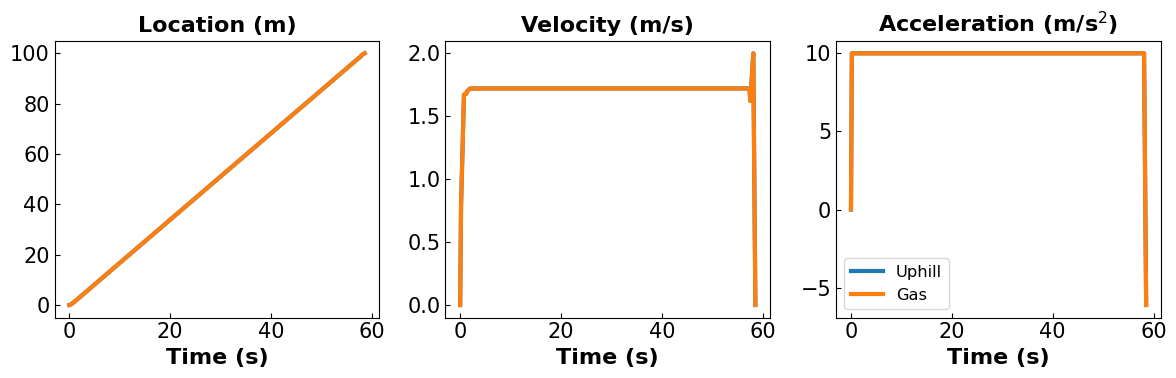

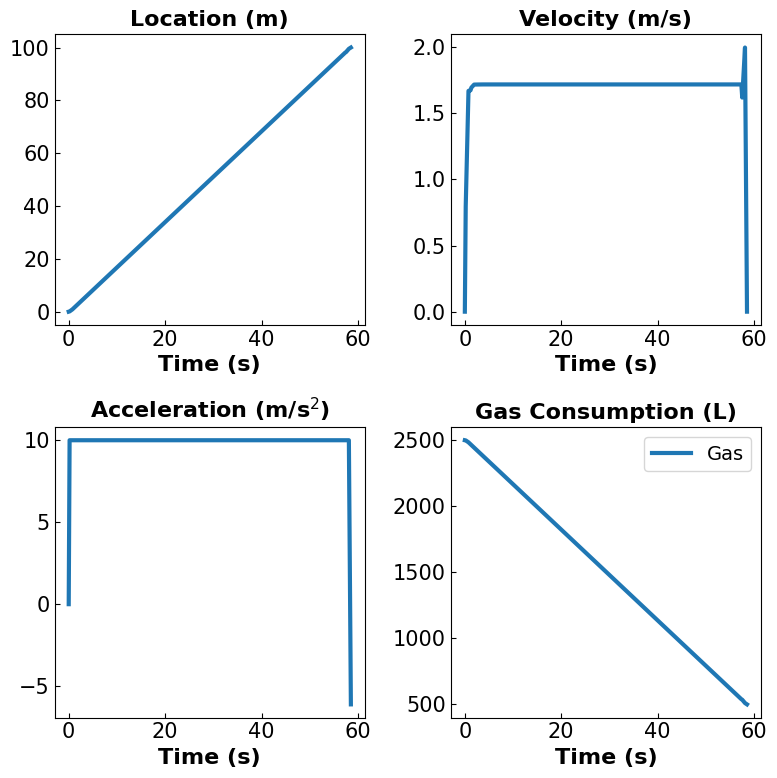

In [ ]:
# Uphill Model
m_checking = friction_uphill_model(0.4,0.1,np.pi/12)
m_checking = model_solve(m_checking)
time1, x1, v1, u1 = data_extract(m_checking)

# Gas Consumption Model with Enough Gas
m_gas = gas_consumption_model(0.4,0.1,2500,np.pi/12)
m_gas = model_solve(m_gas)
time2, x2, v2, u2 = data_extract(m_gas)
time3, x3, v3, u3, G3 = data_gas(m_gas)

data_dict1 = {
    "Uphill": (time1, x1, v1, u1),
    "Gas": (time2, x2, v2, u2)
}

data_dict2 = {
    "Gas": (time3, x3, v3, u3, G3)
}

plot_data(data_dict1)
plot_gas(data_dict2)

In [ ]:
G3[0]- G3[-1]

1992.6699874529236

**Putting it all togethor**

final time =  94.73 seconds
final time =  69.02 seconds
final time =  58.54 seconds


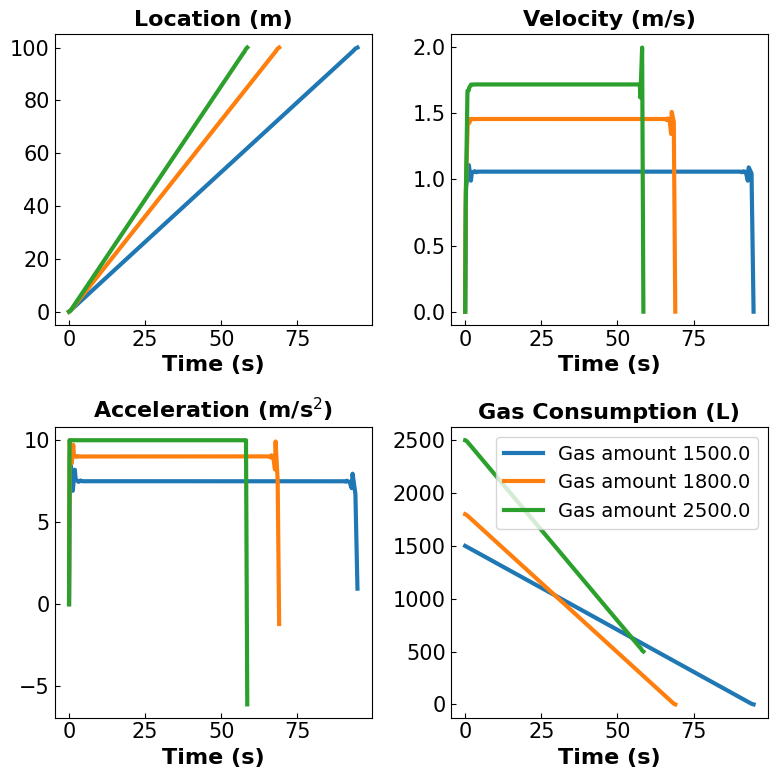

In [33]:
angle = np.pi/12
gas = [1500,1800,2500]
data_dict2 = {}

for i, gas in enumerate(gas):
    # Create and solve the model for each angle
    m_i = gas_consumption_model(0.4,0.1,gas, angle)
    m_i = model_solve(m_i)

    # Extract the data
    time_i, x_i, v_i, u_i,g_i = data_gas(m_i)

    # Convert the angle to degrees for a clearer label
    angle_deg = np.degrees(angle)
    model_label = f"Gas amount {gas:.1f}"

    # Store the data in the dictionary
    data_dict2[model_label] = (time_i, x_i, v_i, u_i, g_i)


plot_gas(data_dict2)

In this formulation, we extend the original problem by incorporating additional complexities that reflect more realistic constraints. We introduce a fuel consumption model through the state variable G(τ), representing the remaining fuel. The differential equation for G(τ) takes into account the control input u, drag forces, and gravitational forces associated with motion on a sloped surface. By including a slope component characterized by ϕ, we capture the effects of gravity more accurately, considering both the tangential and normal components of gravitational force. These additions go beyond the original model by introducing a fuel usage constraint and a sloped terrain, providing a richer, more nuanced description of the system dynamics. The inclusion of fuel consumption allows us to investigate trade-offs between travel time and fuel efficiency, while the slope parameter introduces asymmetries in the acceleration and deceleration phases of the motion, adding depth to the optimization problem.

# References

Michael L. Bynum, Gabriel A. Hackebeil, William E. Hart, Carl D. Laird, Bethany L. Nicholson, John D. Siirola, and David L. Woodruff. Pyomo — Optimization Modeling in Python. Springer Optimization and Its Applications. Springer, Cham, 3 edition, 2021.

Benedek Csercsik. Pyomo.dae car example. https://ndcbe.github.io/optimization/notebooks/3/PyomoDAE_car.html. Accessed: 2024-09-05.

OpenMDAO Development Team. Dymos mountain car example. https://openmdao.github.io/dymos/examples/mountain_car/mountain_car.html. Accessed: 2024-09-
05.





